In [9]:
''' This is the main script to run the DQN algorithm. '''
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import time
import json
import math
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname("run_script.ipynb"))))))


In [10]:
# import neccessary modules
from Top_Opt_RL.DQN.FEA_SOLVER_GENERAL import *
from Top_Opt_RL.DQN.opts import parse_opts
from Top_Opt_RL.DQN.TopOpt_Env_Functions import TopOpt_Gen, Prog_Refine_Act,User_Inputs,App_Inputs, Testing_Inputs, Testing_Info, Min_Dist_Calc  
from Top_Opt_RL.DQN.Matrix_Transforms import obs_flip, action_flip, Mesh_Transform, Mesh_Triming 
from Top_Opt_RL.DQN.RL_Necessities import Agent 

In [11]:
'''
function to plot learning curve
dependancy: matplotlib
input: x (Episode number), y (Average Reward), filename (name of the file to save the plot)
output: none
'''
def plot_learning_curve(x, scores, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    running_average = np.zeros(len(scores))
    for i in range(len(scores)):
        running_average[i] = np.mean(scores[max(0, i-50):(i+1)])
    
    plt.title('Running average of previous 100 scores')    
    ax.plot(x, running_average, color="blue")
    ax.set_xlabel("Episodes", color="black")
    ax.set_ylabel("Average Reward", color="black")
    ax.tick_params(axis='x', colors="black")
    ax.tick_params(axis='y', colors="black")

    plt.savefig(filename)

# test of the plot_learning_curve function
# x = [i+1 for i in range(100)]
# y = [i+1 for i in range(100)]
# plot_learning_curve(x, y, "test.png")

In [12]:
''' 
This function stores the data history 
'''
def Data_History(score_history, per_history, succ_history, Loss_history, Total_Loss, score, Main_EX, Main_EY,i):

    Loss_history.append(Total_Loss)
    avg_Loss=np.mean(Loss_history[-50:])
    score_history.append(score)
    avg_score = np.mean(score_history[-50:])
    Succ_Steps=list(env.VoidCheck).count(0)
    succ_history.append(Succ_Steps)

    avg_succ = np.mean(succ_history[-50:])
    Percent_Succ=Succ_Steps/(Main_EX*Main_EY)
    per_history.append(Percent_Succ)
    avg_percent=np.mean(per_history[-50:])
    return score_history,per_history,succ_history,Loss_history,Succ_Steps,Percent_Succ,avg_succ,avg_score,avg_Loss,avg_percent

In [13]:
''' 
This is the main topopt function
'''

def TopOpt_Designing(User_Conditions, opts, envs): #,my_call_back_functions):
    Time_Trial = opts.Time_Trial
    if opts.Progressive_Refinement:
        agent_primer= Agent(envs.env_primer,opts,Increase=False,filename_save=opts.filename_save+str(opts.PR_EX)+'by'+str(opts.PR_EY),
                            filename_load=opts.filename_load,EX=opts.PR_EX,EY=opts.PR_EY, n_actions=opts.PR_EX*opts.PR_EY,
                            epsilon=0,input_dims=[opts.PR_EX,opts.PR_EY,3])
                            
        agent_primer2= Agent(envs.env_primer2,opts,Increase=False,filename_save=opts.filename_save+str(opts.PR2_EX)+'by'+str(opts.PR2_EY),
                            filename_load=opts.filename_load,EX=opts.PR2_EX,EY=opts.PR2_EY, n_actions=opts.PR2_EX*opts.PR2_EY, 
                            epsilon=0,input_dims=[opts.PR2_EX,opts.PR2_EY,3])
        agent_primer.load_models()
        agent_primer2.load_models()
    
    agent = Agent(envs.env,opts,Increase=False,filename_save=opts.filename_save+str(opts.Main_EX)+'by'+str(opts.Main_EY),
                  filename_load=opts.filename_load,EX=opts.Main_EX,EY=opts.Main_EY, n_actions=opts.Main_EX*opts.Main_EY, 
                  epsilon=1.0, input_dims=[opts.Main_EX,opts.Main_EY,3])
    if opts.Load_Checkpoints: agent.load_models()    
    figure_file = 'plots/' + opts.filename_save +'_reward.png'    
    best_score = envs.env.reward_range[0]    
    score_history ,per_history,succ_history,Loss_history= [],[],[],[]
    
    if not opts.Load_Checkpoints:
        from pandas import DataFrame 
        TrialData=DataFrame(columns=['Episode','Reward','Successfull Steps','Percent Successful','Avg Loss','SDEV','Epsilon','Time'])
    envs.env.reset_conditions()
    if opts.From_App:  opts.n_games=1
    for i in range(opts.n_games):
        Testing = False #Used to render the environment and track learning of the agent 
        if opts.Load_Checkpoints:
            'If the user wants to test the agent, the user will be prompted to input BC and LC elements'
            if opts.From_App:  App_Inputs(envs.env,envs.env_primer,envs.env_primer2,opts,User_Conditions)

            else:  User_Inputs(envs.env,opts)

        done = False
        score = 0    
        if i%10==0 and i>=100:
            Testing=True
            if i%200==0:
                'Every 200 episodes, a special BC/LC will be used for monitoring purposes'
                Testing_Inputs(envs.env,opts)
                print('--------Testing Run------')
        envs.env.VoidCheck=list(np.ones((1,envs.env.EX*envs.env.EY))[0])
        if Time_Trial:     Start_Time_Trial=time.perf_counter()
        observation = envs.env.reset()
        print(envs.env)
        if opts.Progressive_Refinement:
            ''' Set Up to Complete 3 Iterations of Progressive Refinement'''
            #Progressive Refinement #1 Going from Smallest to Intermediate Mesh Size
            envs.env_primer.VoidCheck=list(np.ones((1,envs.env_primer.EX*envs.env_primer.EY))[0])
            Prog_Refine_Act(agent_primer,envs.env,envs.env_primer,opts.Load_Checkpoints,Testing,opts,opts.PR_EX,opts.PR_EY,Time_Trial,opts.From_App,FEA_Skip=1)
            #Progressive Refinement #2 Going for Intermediate to Final Mesh Size
            envs.env_primer2.VoidCheck=Mesh_Transform(opts.PR_EX,opts.PR_EY,opts.PR2_EX,opts.PR2_EY,envs.env_primer.VoidCheck)
            if opts.From_App:
                del agent_primer
            Prog_Refine_Act(agent_primer2,envs.env,envs.env_primer2,opts.Load_Checkpoints,Testing,opts,opts.PR2_EX,opts.PR2_EY,Time_Trial,opts.From_App,FEA_Skip=1)
            #This outcome will now be used as the final mesh Size 
            envs.env.VoidCheck=Mesh_Transform(opts.PR2_EX,opts.PR2_EY,opts.Main_EX,opts.Main_EY,envs.env_primer2.VoidCheck)
            if opts.From_App:
                del agent_primer2
            #Removed_Num=Mesh_Triming(env_primer,PR_EX,PR_EY)
            #Uncomment the above line if you want to incorporate mesh trimming

            observation[:,:,0]=np.reshape(FEASolve(envs.env.VoidCheck,opts.Lx,opts.Ly,opts.Main_EX,opts.Main_EY,envs.env.LC_Nodes,envs.env.Load_Directions,envs.env.BC_Nodes,Stress=True)[3],(opts.Main_EX,opts.Main_EY))
        observation_v, observation_h,observation_vh=obs_flip(observation,opts.Main_EX,opts.Main_EY)
        Last_Reward=0
        while not done:
            if i%1000==0 and i>=1: #Every 1000 iterations, show the activation maps
                from keract import get_activations, display_activations 
                activations = get_activations(agent.q_eval.model, observation.reshape(-1,opts.Main_EX,opts.Main_EY,3))
                display_activations(activations, save=False)
            action = agent.choose_action(observation,opts.Load_Checkpoints,Testing)
            observation_, reward, done, It= envs.env.step(action,observation,Last_Reward,opts.Load_Checkpoints,envs.env,FEA_Skip=1,PR=False)
            if not opts.Load_Checkpoints:
                observation_v_,observation_h_,observation_vh_=obs_flip(observation_,opts.Main_EX,opts.Main_EY)
                action_v,action_h,action_vh=action_flip(action,opts.Main_EX,opts.Main_EY)
                agent.store_transition(observation,action,reward,observation_,done)
                agent.store_transition(observation_v,action_v,reward,observation_v_,done)
                agent.store_transition(observation_h,action_h,reward,observation_h_,done)
                agent.store_transition(observation_vh,action_vh,reward,observation_vh_,done)
            score += reward
            App_Plot=Testing_Info(envs.env,envs.env_primer,envs.env_primer2,opts,score,opts.Progressive_Refinement,opts.From_App,Fixed=True)
            # _=[fn(App_Plot) for fn in my_call_back_functions]
            Last_Reward=reward
            if Testing and not Time_Trial:
                envs.env.render()
                print('Current Score: '+str(round(score,3)))
            observation = observation_
            if not opts.Load_Checkpoints:
                observation_v=observation_v_
                observation_h=observation_h_
                observation_vh=observation_vh_
            if opts.Load_Checkpoints and not Time_Trial:   envs.env.render()
        App_Plot=Testing_Info(envs.env,envs.env_primer,envs.env_primer2,opts,score,opts.Progressive_Refinement,opts.From_App,Fixed=True)
        # _=[fn(App_Plot) for fn in my_call_back_functions]
        return App_Plot        
        toc=time.perf_counter()

        if Time_Trial and not opts.From_App:
            print('It took '+str(round(toc-Start_Time_Trial,1))+' seconds to complete this time trial.')    

        App_Plot=Testing_Info(envs.env,envs.env_primer,envs.env_primer2,opts,score,opts.Progressive_Refinement,opts.From_App,Fixed=True)

In [14]:
''' RL environment class'''
class EnviromentsRL:
    def __init__(self, opts):
        if opts.Load_Checkpoints:
            SC=opts.SC
            if opts.VF_S==0 and opts.From_App: #If the user wants to set a final volume fraction, set the intermediate volume fractions accordingly
                Vol_Frac_2=opts.Vol_Frac_2
                Vol_Frac_1=opts.Vol_Frac_1
                Vol_Frac_3=opts.Vol_Frac_3 
        else:
            Vol_Frac_3=opts.Vol_Frac_3
            Vol_Frac_1=opts.Vol_Frac_1
            Vol_Frac_2=opts.Vol_Frac_2
        self.env = TopOpt_Gen(opts.Main_EX,opts.Main_EY,Vol_Frac_3,SC,opts)
        self.env_primer= TopOpt_Gen(opts.PR_EX,opts.PR_EY,Vol_Frac_1,SC,opts)
        self.env_primer2=TopOpt_Gen(opts.PR2_EX,opts.PR2_EY,Vol_Frac_2,SC,opts)

In [15]:
''' 
Class for Topology Optimization Options
'''
class Top_Options:
    def __init__(self, Main_EX=24, Main_EY=24, PR2_EX=12, PR2_EY=12, PR_EX=6, PR_EY=6, Lx=1, Ly=1, Eta=2, a=5, b=5, replace=100, epsilon_dec=3.5e-4, eps_end=0.01, mem_size=30000, n_games=50000, batch_size=128, lr=5e-3, gamma=0.1, Vol_Frac_1=0.7, Vol_Frac_2=0.5, Vol_Frac_3=0.25, SC=10, P_Norm=10, filename_save='DDQN_TopOpt_Generalized_CNN_4L', filename_load='DDQN_TopOpt_Generalized_CNN_4L_6by6', Progressive_Refinement=True, LC=False, Load_Checkpoints=True, VF_S=0, Min_Dist=0, Time_Trial=True, configfile='config.json', From_App=True, base_folder="."):
        self.Main_EX = Main_EX  # Number of X Elements for Larger Environment
        self.Main_EY = Main_EY  # Number of Y Elements for Larger Environment
        self.PR2_EX = PR2_EX  # Number of X Elements for Second Environment used in Case of Progressive Refinement
        self.PR2_EY = PR2_EY  # Number of Y Elements for Second Environment used in Case of Progressive Refinement
        self.PR_EX = PR_EX  # Number of X Elements for Smaller Environment used in Case of Progressive Refinement
        self.PR_EY = PR_EY  # Number of Y Elements for Smaller Environment used in Case of Progressive Refinement
        self.Lx = Lx  # Length of the Structure in the X Direction
        self.Ly = Ly  # Length of the Structure in the Y Direction
        self.Eta = Eta  # Used for dynamic adjusting reward function. Larger eta means less prevalence given towards changes between current and previous reward. Recommend using [2,4]
        self.a = a  # X Coefficient of the Quadratic Reward Surface
        self.b = b  # Y Coefficient of the Quadratic Reward Surface
        self.replace = replace  # Number of iterations between switching the weights from the active network to the target network
        self.epsilon_dec = epsilon_dec  # Iterative decay amount of the epsilon value used for exploration/explotation
        self.eps_end = eps_end  # Smallest Allowable Epsilon value to be used for exploration/explotation
        self.mem_size = mem_size  # Size of the Replay Buffer
        self.n_games = n_games  # Maximum Number of Training Episodes Conducted
        self.batch_size = batch_size  # Batch Size that will be taken from the Replay Buffer per training episode
        self.lr = lr  # Starting Learning Rate for the Network
        self.gamma = gamma  # Discount Factor for Future Rewards
        self.Vol_Frac_1 = Vol_Frac_1  # Volume Fraction during first progressive refinement
        self.Vol_Frac_2 = Vol_Frac_2  # Final Volume Fraction
        self.Vol_Frac_3 = Vol_Frac_3  # Final Volume Fraction
        self.SC = SC  # Stress constraint, between 0 and 2
        self.P_Norm = P_Norm  # Smoothing Parameter for P-Norm Global Stress calculation
        self.filename_save = filename_save  # When training, what name would you like your weights, and figure saved as
        self.filename_load = filename_load  # When testing, what name is your NN weights saved under
        self.Progressive_Refinement = Progressive_Refinement
        self.LC = LC # type in loading conditions manually
        self.Load_Checkpoints = Load_Checkpoints
        self.VF_S = VF_S # Use vol fraction constraint [0] or stress constraint [1]
        self.Min_Dist = Min_Dist # The 0 value serves as a place holder to represent the minimum distance between the bounded and loaded elements in a given load case
        self.Time_Trial = Time_Trial # Perform Time Trial
        self.configfile = configfile # name of config file. 
        self.From_App = From_App # True if being called by an external app. Not sure this is needed. "
        self.base_folder = base_folder # Folder where to find saved files. Helpful if not running the app from the main folder. 



... loading models ...
... loading models ...
... loading models ...
<TopOpt_Gen instance>


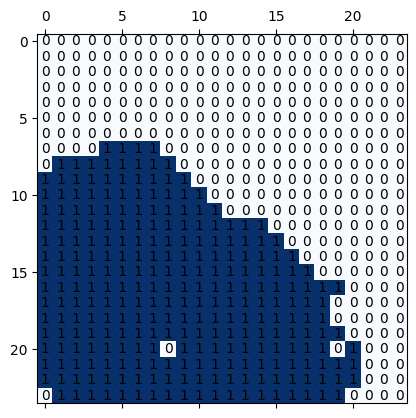

<module 'read_app_data' from '/home/csmd_chung/jupyter_projects/Top_Opt_RL/DQN/read_app_data.py'>

In [16]:
opts = Top_Options()
User_Conditions = json.load(open(opts.configfile) ) if opts.From_App else None  
opts = Top_Options()
envs = EnviromentsRL(opts)  
App_Plot=TopOpt_Designing(User_Conditions,opts, envs)
json.dump( App_Plot, open( "App_Data.json", 'w' ) )
import read_app_data
read_app_data